# Use IMPA to transform BBBC021 

Import libraries 

In [120]:
# Standard library imports
import os
from pathlib import Path

# Third-party library imports
from tutorial_utils import t2np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml 
import torch
from omegaconf import OmegaConf
from tqdm import tqdm

# Local application/library imports
from IMPA.dataset.data_loader import CellDataLoader
from IMPA.solver import IMPAmodule

Read the configuration of interest 

In [121]:
path_to_config = "../config_hydra/config/bbbc021_six.yaml"

In [122]:
# Reading the YAML file
with open(path_to_config, 'r') as file:
    config = yaml.safe_load(file)  # Use safe_load to avoid executing arbitrary code

# Access the loaded data
print(config)

{'task_name': 'bbbc021_six', 'img_size': 96, 'latent_dim': 1024, 'hidden_dim': 512, 'style_dim': 64, 'stochastic': True, 'z_dimension': 16, 'dim_in': 64, 'lambda_reg': 1, 'lambda_cyc': 1, 'lambda_sty': 1, 'lambda_ds': 1, 'total_epochs': 200, 'ds_iter': 100000, 'resume_iter': 0, 'batch_size': 32, 'val_batch_size': 20, 'lr': 0.0001, 'f_lr': 0.0001, 'beta1': 0, 'beta2': 0.99, 'weight_decay': 0.0001, 'num_outs_per_domain': 10, 'single_style': True, 'ood_set': None, 'mol_list': ['AZ138', 'AZ258', 'cytochalasin B', 'DMSO', 'taxol', 'vincristine'], 'balanced': False, 'trainable_emb': False, 'dataset_name': 'bbbc021', 'n_channels': 3, 'num_workers': 6, 'seed': 42, 'multimodal': False, 'batch_correction': False, 'batch_key': None, 'use_condition_embeddings': False, 'add_controls': False, 'condition_embedding_dimension': None, 'modality_list': ['Compound'], 'image_path': 'project_folder/datasets/bbbc021_six', 'data_index_path': 'project_folder/datasets/bbbc021_six/metadata/bbbc021_df_six.csv', '

In [123]:
config["image_path"] = "../" + config["image_path"]
config["data_index_path"] = "../" + config["data_index_path"]
config["embedding_path"] = "../" + config["embedding_path"]

Create an omega config dict

In [124]:
args = OmegaConf.create(config)

#### Initialize data loader

In [125]:
dataloader = CellDataLoader(args)

['transform_cells_bbbc021_six_drugs.ipynb', 'transform_cells_cpg0000_batch_corr.ipynb', 'transform_cells_rxrx1_batch_corr.ipynb', '__pycache__', 'transform_cells_bbbc021_all_unseen_prediction.ipynb', '.ipynb_checkpoints', 'transform_cells_cpg0000_pert_prediction.ipynb', 'tutorial_utils.py']


#### Initialize model 

In [126]:
checkpoint_dir = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20241126_6a2a3e23-a23e-4f1d-9c83-3dc92929d6be_bbbc021_six"

In [127]:
solver = IMPAmodule(args, checkpoint_dir, dataloader)
solver._load_checkpoint(200)

Number of parameters in generator: 24318595
Number of parameters in style_encoder: 14329472
Number of parameters in discriminator: 14299205
Number of parameters in mapping_network: 66624
Initializing embedding_matrix...
Initializing generator...
Initializing style_encoder...
Initializing discriminator...
Initializing mapping_network...
IMPAmodule(
  (embedding_matrix): Embedding(5, 1024)
  (generator): DataParallel(
    (module): Generator(
      (from_rgb): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (encode): ModuleList(
        (0): ResBlk(
          (actv): LeakyReLU(negative_slope=0.2)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False

**Check what molecules we have and their encodings**

In [128]:
train_dataloader = dataloader.train_dataloader()
val_dataloader = dataloader.val_dataloader()

In [129]:
dataloader.mol2id

{'AZ138': 0, 'AZ258': 1, 'cytochalasin B': 2, 'taxol': 3, 'vincristine': 4}

**Tranform controls to perturbed**

In [133]:
# Initilize empty dictionaries 
controls = []
transformed = {}

with torch.no_grad():
    for i, (drug, drug_id) in enumerate(dataloader.mol2id.items()):
        print(f"Transforming images for {drug}")
        transformed[drug] = []
        for batch in tqdm(dataloader.train_dataloader()):
            X_ctr = batch["X"][0]
            # z original and z transported
            z = torch.randn(X_ctr.shape[0], 100, args.z_dimension).cuda().mean(1)
    
            # Perturbation ID 
            id_pert = dataloader.mol2id[drug] * torch.ones(X_ctr.shape[0]).long().cuda()
            y = solver.embedding_matrix(id_pert)
            y = torch.cat([y, z], dim=1)
            y = solver.nets.mapping_network(y)
    
            _, X_generated = solver.nets.generator(X_ctr, y)

            if i==0:
                controls.append(t2np(X_ctr.detach().cpu(), batch_dim=True))
            transformed[drug].append(t2np(X_generated.detach().cpu(), batch_dim=True))
            
controls = np.concatenate(controls, axis=0) 
transformed = {key: np.concatenate(val, axis=0) for key, val in transformed.items()}

Transforming images for AZ138


100%|██████████| 146/146 [00:09<00:00, 15.73it/s]


Transforming images for AZ258


100%|██████████| 146/146 [00:08<00:00, 17.26it/s]


Transforming images for cytochalasin B


100%|██████████| 146/146 [00:08<00:00, 16.77it/s]


Transforming images for taxol


100%|██████████| 146/146 [00:08<00:00, 17.10it/s]


Transforming images for vincristine


100%|██████████| 146/146 [00:08<00:00, 17.25it/s]


Control 0


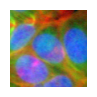

Control 1


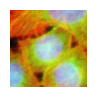

Control 2


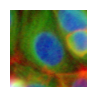

Control 3


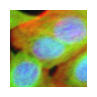

In [134]:
for i in range(len(controls)):
    print(f"Control {i}")
    plt.figure(figsize=(1, 1))
    plt.imshow(controls[i])
    plt.axis("off")
    plt.show()
    if i==3:
        break

Perturbation AZ138


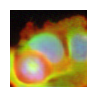

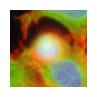

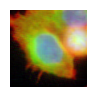

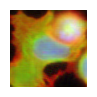

Perturbation AZ258


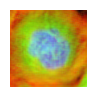

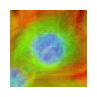

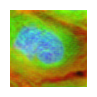

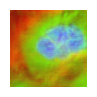

Perturbation cytochalasin B


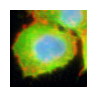

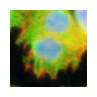

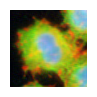

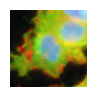

Perturbation taxol


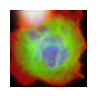

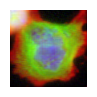

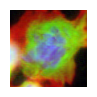

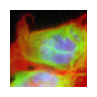

Perturbation vincristine


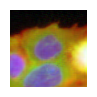

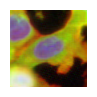

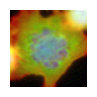

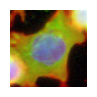

In [135]:
for pert in transformed:
    print(f"Perturbation {pert}")
    for i in range(len(transformed[pert])):
        plt.figure(figsize=(1, 1))
        plt.imshow(transformed[pert][i])
        plt.axis("off")
        plt.show()
        if i==3:
            break

In [136]:
import scipy

In [137]:
scipy.__version__

'1.9.1'